In [138]:
from sklearn import datasets
import pandas as pd

#'../data/df_com_all_2/'+route_name+'_'+i+'_'+str(days_ago)+'.csv'
route_name = "hatoma_route"
dep = "hatoma_dep"
days_ago = 5

df = pd.read_csv('../data/df_com_all_2/'+route_name+'_'+dep+'_'+str(days_ago)+'.csv', header=None)

df = df.dropna(subset=[1])

import numpy as np
from sklearn.preprocessing import LabelEncoder
#データのロード
X = df.iloc[:,3:12].values
print(X)
y = df.loc[:, 1]#.values
print(y)

[[ 9.   nan  0.5 ...  0.8  nan  5. ]
 [40.   nan  1.7 ...  2.5  nan 25. ]
 [16.   nan  1.2 ...  1.7  nan 11. ]
 ...
 [14.  53.   0.8 ...  1.3 42.   8. ]
 [27.  20.   0.8 ...  1.6 19.  20. ]
 [25.  17.   0.8 ...  1.3 34.  15. ]]
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3191    1.0
3192    1.0
3193    1.0
3194    1.0
3195    1.0
Name: 1, Length: 3164, dtype: float64


In [139]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,730.0,0.0,2020-08-18,9,NaN,0.5,NaN,8.4,6,0.8,NaN,5
1,730.0,0.0,2020-09-06,40,NaN,1.7,NaN,10.5,6,2.5,NaN,25
2,730.0,0.0,2020-09-07,16,NaN,1.2,NaN,10.0,6,1.7,NaN,11
3,730.0,0.0,2020-09-08,16,NaN,1.4,NaN,10.1,6,1.6,NaN,11
4,730.0,0.0,2020-09-09,9,NaN,0.7,NaN,9.8,6,0.9,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3191,1605.0,1.0,2020-12-14,26,65.0,1.5,360.0,6.5,18,2.2,38.0,18
3192,945.0,1.0,2020-12-16,21,65.0,1.0,11.0,7.0,9,1.4,38.0,15
3193,1605.0,1.0,2020-12-16,14,53.0,0.8,352.0,6.0,18,1.3,42.0,8
3194,945.0,1.0,2020-12-17,27,20.0,0.8,114.0,8.6,9,1.6,19.0,20


In [140]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))

Labels counts in y[0 1]: [2770  394]
Labels counts in y_train[0 1]: [2216  315]
Labels counts in y_test[0 1]: [554  79]


In [141]:
#標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(X_train_std)

[[-1.13872456  0.90934069 -0.40407651 ... -0.5338563  -0.32603287
  -0.97275375]
 [ 0.35014706 -0.44647896  2.4433972  ...  0.89131325  0.62148983
   0.26119675]
 [-1.02419597  0.50003665 -1.11594493 ... -1.05209977  1.02757099
  -0.97275375]
 ...
 [-0.7951388  -0.28019919  0.78237087 ... -0.27473456  0.21540867
  -0.51002231]
 [ 1.83901867 -0.65113098  0.07050244 ...  1.66867846 -0.91259454
   1.80363488]
 [ 1.15184716 -0.31857144  1.4942393  ...  1.53911759 -0.46139326
   1.34090344]]


In [142]:
import lightgbm as lgb
def train_data(X_train, y_train):
    """学習用データの作成
        Args:
            X_train:
                学習用のトレーニングデータ
            y_train:
                学習用のラベルデータ

        Returns:
            lgb.Dataset(X_train, label=y_train):
                学習用データの作成
    """
    return lgb.Dataset(X_train, label=y_train)

train_data=train_data(X_train, y_train)

In [143]:
# テストデータの作成    
def test_data(X_test, y_test, train_data):
    """テストデータの作成
        Args:
            X_test:
                学習用のtestデータ
            y_test:
                学習用のtestデータ

        Returns:
            lgb.Dataset(X_test, label=y_test, reference=train_data):
                学習用データの作成
    """
    return lgb.Dataset(X_test, label=y_test, reference=train_data)
test_data = test_data(X_test, y_test, train_data)

In [160]:
boostring='dart'
learning_rate=0.05
min_data_in_leaf=20
#applications='binary'
feature_fraction=0.7
num_leaves=41
metric='auc'#'binary_logloss'#'auc'
drop_date=0.15
objective = "binary"
#application = applications
parameters = {
            'boosting': boostring,          # dart (drop out trees) often performs better
            'objective': objective,
            #'application': applications,     # Binary classification
            'learning_rate': learning_rate,       # Learning rate, controls size of a gradient descent step
            'min_data_in_leaf': min_data_in_leaf,      # Data set is quite small so reduce this a bit
            'feature_fraction': feature_fraction,     # Proportion of features in each boost, controls overfitting
            'num_leaves': num_leaves,            # Controls size of tree since LGBM uses leaf wise splits
            'metric': metric,  # Area under ROC curve as the evaulation metric
            'drop_rate': drop_date   
        }


In [161]:
def fit(train_data, test_data, parameters, batch=100):
    """学習を行う
        Args:
            train_data:
                学習用trainデータ
            test_data:
                学習用testデータ
            batch:
                学習回数
                初期値は100
    """
    evaluation_results = {}
    model=lgb.train(parameters,
                    train_data,
                    valid_sets=[train_data, test_data], 
                    valid_names=['Train', 'Test'],
                    evals_result = evaluation_results,
                    num_boost_round=batch,
                    early_stopping_rounds=50,
                    verbose_eval=20)
    return model,evaluation_results
    #optimum_boost_rounds = self.model.best_iteration
model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

[LightGBM] [Info] Number of positive: 315, number of negative: 2216
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 2531, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124457 -> initscore=-1.950886
[LightGBM] [Info] Start training from score -1.950886


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	Train's auc: 0.948037	Test's auc: 0.891617
[40]	Train's auc: 0.95339	Test's auc: 0.895935
[60]	Train's auc: 0.955255	Test's auc: 0.900871
[80]	Train's auc: 0.955864	Test's auc: 0.901396
[100]	Train's auc: 0.956311	Test's auc: 0.900414


In [162]:
def predict(model,X_test):
    """予測を行う
        Args:
            X_test:
                予測をしたいデータ
        Returns:
            model.predict(X_test):
                予測結果
    """
    return model.predict(X_test)
y_pred_proba = predict(model,X_test)
#print(y_pred_proba)
y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
print(y_pred)
y_train_proba = predict(model,X_train)
y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

def accuracy_rate(y_test,y_pred):
    """予測結果から正解率を表示
        Args:
            y_test:
                予測に使用したデータのラベル(目的変数)
            y_pred:
                予測結果
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC",auc)

y_pred = pd.Series(y_pred)
#print(y_test,y_pred)
#print(y_test)
#print(y_pred_proba)
accuracy_rate(y_test,y_pred_proba)
accuracy_rate(y_test,y_pred)
accuracy_rate(y_train,y_pred_train)
#print('Test Accuracy: %.3f' % model.score(X_test, y_test))
print(accuracy_score(y_test, y_pred))
print(y_pred)

AUC 0.9004135630398026
AUC 0.6193849106612438
AUC 0.6989191163830154
0.8751974723538705
0      0
1      0
2      0
3      0
4      0
      ..
628    1
629    0
630    0
631    1
632    0
Length: 633, dtype: int64


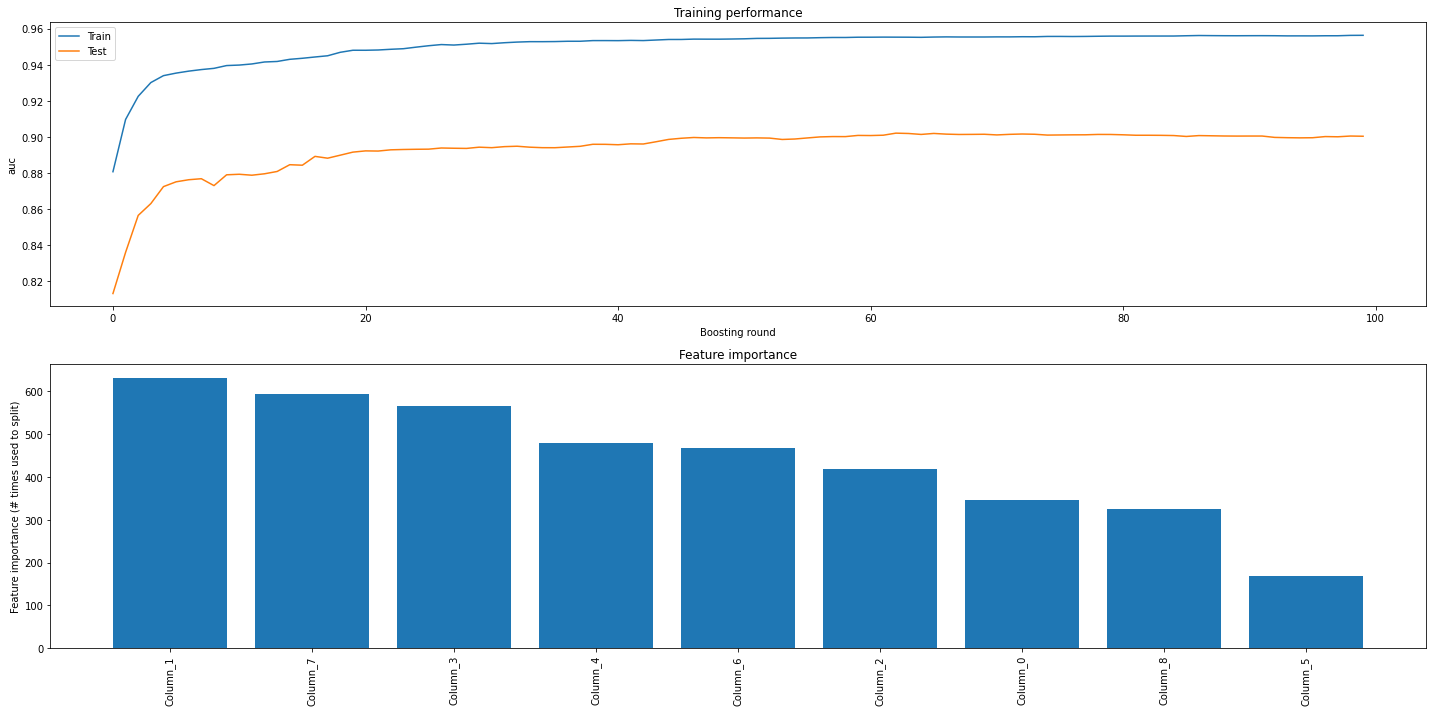

In [136]:
import matplotlib.pyplot as plt
def plot_imp():
    """学習後にtrain,testそれぞれの学習回数ごとのAccuracyグラフと特徴量の重要度のグラフ表示
    """
    fig, axs = plt.subplots(2, 1, figsize=[20, 10])

    # Plot the log loss during training
    axs[0].plot(evaluation_results['Train']['auc'], label='Train')
    axs[0].plot(evaluation_results['Test']['auc'], label='Test')
    axs[0].set_ylabel('auc')
    axs[0].set_xlabel('Boosting round')
    axs[0].set_title('Training performance')
    axs[0].legend()

    # Plot feature importance
    importances = pd.DataFrame({'features': model.feature_name(), 
                                'importance': model.feature_importance()}).sort_values('importance', ascending=False)
    axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
    axs[1].set_xticks(np.arange(len(importances)))
    axs[1].set_xticklabels(importances['features'])
    axs[1].set_ylabel('Feature importance (# times used to split)')
    axs[1].set_title('Feature importance')

    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.show()
    plt.savefig("重要度.png")

plot_imp()

[[532  22]
 [ 57  22]]


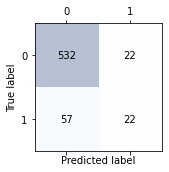

In [137]:
#混同行列
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()